# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [3]:
## import human data for fitting
import pandas as pd
hdf = pd.read_csv('../human_data.csv')
humanB_acc,humanI_acc = hdf.loc[:,('blocked mean','interleaved mean')].values.T

In [4]:
def get_sm(xth,norm=True):
  """ 
  given x_t_hat from subject
  [trial,layer,node]
  get 2afc normalized softmax for layer 2/3
  return: [layer2/3,trial,node56/78]
  norm=true 
   apply softmax to xth
   when prediction done with multiple schemas
  """
  nodes = {2:(5,6),3:(7,8)} 
  L = [] # layer 2 and 3
  for l,ns in nodes.items():
    y = xth[:,l,ns]
    if norm:
      y=softmax(y,1)
    L.append(y)
  return np.array(L)

def get_acc(data):
  """ 
  returns 2afc softmax of 
  layer 2/3 transitions
  """
  ysm = get_sm(data['xth'])
  L = []
  for i in range(2):
    ysml = ysm[i,:,:]
    yt = data['exp'][:,i+3] 
    pr_yt = ysml[range(len(ysml)),yt - (5+2*i)] # 
    L.append(pr_yt)
  return np.array(L)


In [5]:
### RUN EXP
def run_batch_exp(ns,args):
  """ exp over seeds, single 
  task_condition param config
  return full data
  """
  dataL = []
  for i in range(ns):
    task = Task()
    sem = SEM(args['sch'])
    exp,curr  = task.generate_experiment(**args['exp'])
    data = sem.run_exp(exp)
    data['exp']=exp
    dataL.append(data)
  return dataL

def run_batch_exp_curr(ns,args,currL=['blocked','interleaved']):
  """ loop over task conditions, return accuracy
  return shape [task_condition,seed,trial]
  """
  L = []
  for curr in currL:
    args['exp']['condition'] = curr
    dataL = run_batch_exp(ns,args)
    acc = np.array([get_acc(data) for data in dataL]).mean(1) # mean over layer
    L.append(acc)
  return np.array(L)

In [6]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':1.4,
    'stickiness_wi':5000,
    'stickiness_bt':5, # 100
    'sparsity':0.08,
    'pvar': 2,
    'lrate':0.8,
    'lratep':1,
} 
args = {
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str

'concentration_1.400-stickiness_wi_5000.000-stickiness_bt_5.000-sparsity_0.080-pvar_2.000-lrate_0.800-lratep_1.000'

In [7]:
# p_name = 'concentration' # 
# p_vals = np.arange(0.1,2.5,0.1)

# p_name = 'stickiness_wi' # 5000
# p_vals = np.arange(0,10000,500)

# p_name = 'stickiness_bt' # 100
# p_vals = np.arange(0,10,3)

# p_name = 'sparsity' # 0.08
# p_vals = np.arange(0.01,2,0.05)

# p_name = 'pvar' # 0
# p_vals = np.arange(1,2,0.1)

# p_name = 'lrate' # 1
# p_vals = np.arange(0.1,1.5,0.05)

p_name = 'lratep' # 1
p_vals = np.arange(0.1,2.5,0.1)

p_name,p_vals

('lratep',
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4]))

In [8]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None

In [9]:
ns = 100
L = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  
  args['sch'][p_name] = p_val
  model_seed_acc = run_batch_exp_curr(ns,args,condL) # [B/I,seeds,trials]
  model_acc = model_seed_acc.mean(1)
  model_testacc = model_acc[:,-40:].mean(1)
  
  ## save traces of EML for each param setting
  pltsave_macc(model_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {**schargs,
        **dict(zip(condL,model_testacc))
        }

  L.append(gsD)
gsdf = pd.DataFrame(L)

In [10]:
gsdf

,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,blocked,interleaved,early,middle,late
0,1.4,5000,5,0.08,2,0.8,0.1,1.000000,0.500000,1.000000,1.000000,1.000000
1,1.4,5000,5,0.08,2,0.8,0.2,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.4,5000,5,0.08,2,0.8,0.3,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.4,5000,5,0.08,2,0.8,0.4,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.4,5000,5,0.08,2,0.8,0.5,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.4,5000,5,0.08,2,0.8,0.6,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.4,5000,5,0.08,2,0.8,0.7,1.000000,0.959562,1.000000,0.990875,0.989875
7,1.4,5000,5,0.08,2,0.8,0.8,0.995437,0.859750,1.000000,0.896062,0.865250
8,1.4,5000,5,0.08,2,0.8,0.9,1.000000,0.755187,1.000000,0.800500,0.824500
9,1.4,5000,5,0.08,2,0.8,1.0,0.995000,0.683625,0.994313,0.708625,0.707750


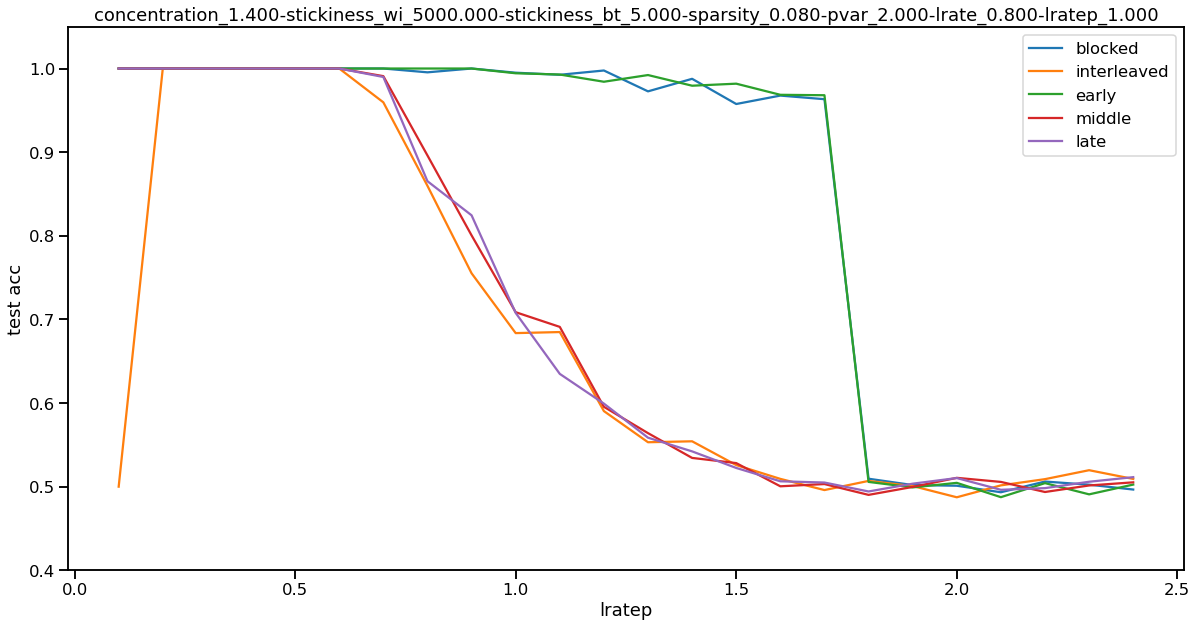

In [11]:
plt.figure(figsize=(20,10))
ax = plt.gca()
gsdf.plot(p_name,condL,ax=ax)
ax.set_ylim(0.4,1.05)
ax.set_ylabel('test acc')
plt.title(param_str)
plt.savefig('figures/scratch/testacc-sweep_%s-default_%s-t%s.png'%(
  p_name,param_str,tstamp))